In [ ]:
import os

# 1. Upload the API Token
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()

# 2. Move Token to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Download the Dataset (Direct from Kaggle)
print("⬇️ Downloading dataset...")
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

# 4. Unzip
print("📂 Unzipping...")
!unzip -q lgg-mri-segmentation.zip -d brain_data

print("✅ Done! Data is ready in the 'brain_data' folder.")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
⬇️ Downloading dataset...
Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 94% 674M/714M [00:03<00:00, 193MB/s]
100% 714M/714M [00:03<00:00, 202MB/s]
📂 Unzipping...
✅ Done! Data is ready in the 'brain_data' folder.


In [ ]:
## importing the dependencies

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
from tqdm.notebook import tqdm

In [ ]:
## device agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Device =  {DEVICE}")

 Device =  cuda


In [ ]:
## data loading
search_path = 'brain_data/**/*_mask.tif'
mask_files = glob.glob(search_path, recursive=True)

if len(mask_files) == 0:
    print("[ERROR] No files found!")
else:
    print(f" Found {len(mask_files)} mask files.")

 Found 7858 mask files.


In [ ]:
## Filtering the dataset for only tumors
def has_tumor(mask_path):
    return np.max(imread(mask_path)) > 0

print("Filtering the dataset for tumors....")
df['has_tumor'] = df['mask'].apply(has_tumor)
df_positive = df[df['has_tumor'] == True]

print(f"Dataset: {len(df)} total -> {len(df_positive)} with tumors.")

Filtering the dataset for tumors....
Dataset: 7858 total -> 2746 with tumors.


In [ ]:
image_files = [m.replace('_mask', '') for m in mask_files]
df = pd.DataFrame({"image": image_files, "mask": mask_files})

In [ ]:
## setting up img and batch size
IMG_SIZE = 256
BATCH_SIZE = 32

In [ ]:
## Splitting the dataset
train_df, val_df = train_test_split(df_positive, test_size=0.1, random_state=42)

In [ ]:
# Custom Dataset
class BrainMRI(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img = imread(self.df.iloc[idx]['image'])
        img = resize(img, (IMG_SIZE, IMG_SIZE), preserve_range=True) / 255.0
        img = np.moveaxis(img, -1, 0)

        mask = imread(self.df.iloc[idx]['mask'])
        mask = resize(mask, (IMG_SIZE, IMG_SIZE), preserve_range=True) / 255.0
        mask = np.expand_dims(mask, axis=0)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

In [ ]:
## Data Loaders
train_loader = DataLoader(BrainMRI(train_df), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(BrainMRI(val_df), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
### U-NET Model
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_c, out_c, 3, 1, 1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                                  nn.Conv2d(out_c, out_c, 3, 1, 1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(3, 64)
        self.d2 = DoubleConv(64, 128)
        self.d3 = DoubleConv(128, 256)
        self.d4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.u3 = DoubleConv(256+512, 256)
        self.u2 = DoubleConv(128+256, 128)
        self.u1 = DoubleConv(64+128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x1 = self.d1(x)
        x2 = self.d2(self.pool(x1))
        x3 = self.d3(self.pool(x2))
        x4 = self.d4(self.pool(x3))
        x = self.u3(torch.cat([self.up(x4), x3], dim=1))
        x = self.u2(torch.cat([self.up(x), x2], dim=1))
        x = self.u1(torch.cat([self.up(x), x1], dim=1))
        return self.final(x)

In [ ]:
## Dice loss
class DiceLoss(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pred, target):
        pred = torch.sigmoid(pred).view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        return 1 - ((2. * intersection + 1) / (pred.sum() + target.sum() + 1))

In [ ]:
# Helper Metric (IoU)
def calculate_iou(pred, target):
    pred = torch.sigmoid(pred) > 0.5
    intersection = (pred & (target > 0.5)).float().sum()
    union = (pred | (target > 0.5)).float().sum()
    return (intersection + 1e-6) / (union + 1e-6)

In [ ]:
def run_experiment(name, loss_fn, epochs=8):
    print(f"\n STARTING: {name}...")
    model = UNet().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
    history = []

    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, leave=False, desc=f"Ep {epoch+1}")
        for img, mask in loop:
            img, mask = img.to(DEVICE), mask.to(DEVICE)
            optimizer.zero_grad()
            loss = loss_fn(model(img), mask)
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

        model.eval()
        val_iou = 0
        with torch.no_grad():
            for img, mask in val_loader:
                img, mask = img.to(DEVICE), mask.to(DEVICE)
                val_iou += calculate_iou(model(img), mask).item()

        avg_iou = val_iou / len(val_loader)
        history.append(avg_iou)
        scheduler.step(avg_iou)
        print(f"   Epoch {epoch+1} | IoU: {avg_iou:.4f}")

    return history, model

In [ ]:
## Running the experiment

bce_hist, model_bce = run_experiment("Baseline (BCE Loss)", nn.BCEWithLogitsLoss())
dice_hist, model_dice = run_experiment("Research Method (Dice Loss)", DiceLoss())


 STARTING: Baseline (BCE Loss)...


Ep 1:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 1 | IoU: 0.4259


Ep 2:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 2 | IoU: 0.5055


Ep 3:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 3 | IoU: 0.4556


Ep 4:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 4 | IoU: 0.3676


Ep 5:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 5 | IoU: 0.4025


Ep 6:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 6 | IoU: 0.6549


Ep 7:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 7 | IoU: 0.6698


Ep 8:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 8 | IoU: 0.6637

 STARTING: Research Method (Dice Loss)...


Ep 1:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 1 | IoU: 0.2657


Ep 2:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 2 | IoU: 0.5370


Ep 3:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 3 | IoU: 0.6252


Ep 4:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 4 | IoU: 0.6277


Ep 5:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 5 | IoU: 0.6431


Ep 6:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 6 | IoU: 0.6023


Ep 7:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 7 | IoU: 0.6938


Ep 8:   0%|          | 0/78 [00:00<?, ?it/s]

   Epoch 8 | IoU: 0.6922


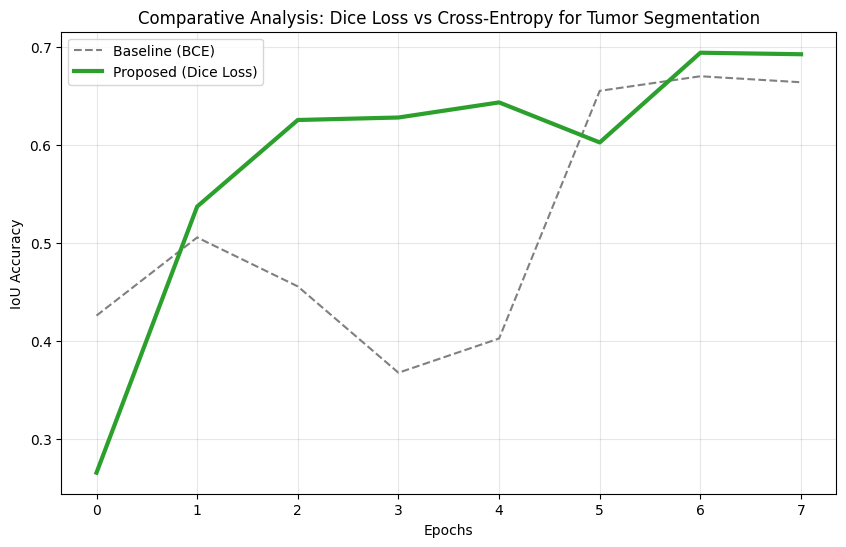

In [ ]:
## Plotting the graphs

plt.figure(figsize=(10,6))
plt.plot(bce_hist, label="Baseline (BCE)", linestyle="--", color="gray")
plt.plot(dice_hist, label="Proposed (Dice Loss)", linewidth=3, color="#2ca02c")
plt.title("Comparative Analysis: Dice Loss vs Cross-Entropy for Tumor Segmentation")
plt.xlabel("Epochs")
plt.ylabel("IoU Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("final_research_graph.png")
plt.show()

In [ ]:
## Plotting the predictions

def plot_prediction(model, dataset, index):
    img, mask = dataset[index]

    model.eval()
    with torch.no_grad():
        img_gpu = img.unsqueeze(0).to(DEVICE)
        pred = model(img_gpu)
        pred = torch.sigmoid(pred) > 0.5 # Convert to Binary (0 or 1)


    img_display = img.permute(1, 2, 0).numpy()
    mask_display = mask.permute(1, 2, 0).numpy()
    pred_display = pred.cpu().squeeze().numpy()

    # 3. Plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original MRI
    ax[0].imshow(img_display)
    ax[0].set_title("Original MRI Scan")
    ax[0].axis("off")

    # Actual tumor figure
    ax[1].imshow(img_display)
    ax[1].imshow(mask_display, cmap="jet", alpha=0.5) # Overlay Red
    ax[1].set_title("Actual Tumor")
    ax[1].axis("off")

    # Tumor Prediction figure
    ax[2].imshow(img_display)
    ax[2].imshow(pred_display, cmap="spring", alpha=0.5) # Overlay Pink/Yellow
    ax[2].set_title("Prediction (Dice Loss)")
    ax[2].axis("off")

    plt.show()

Visualizing Model Performance on Unseen Patients:


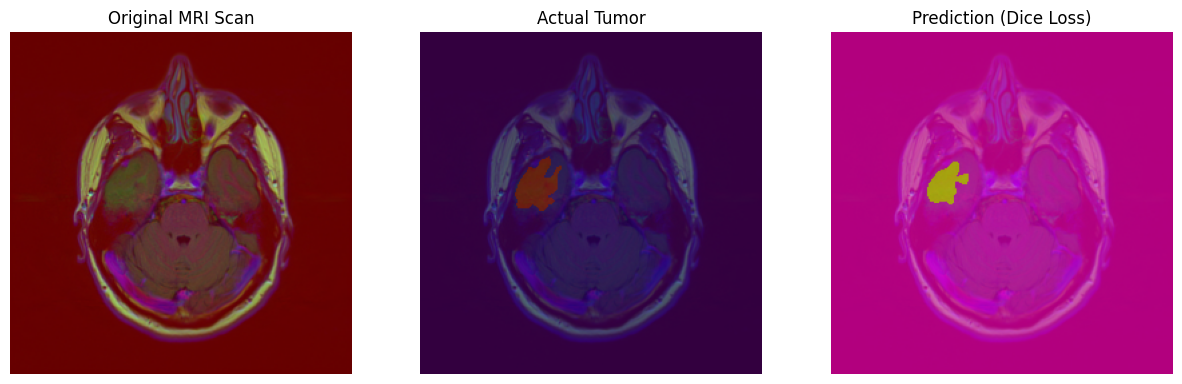

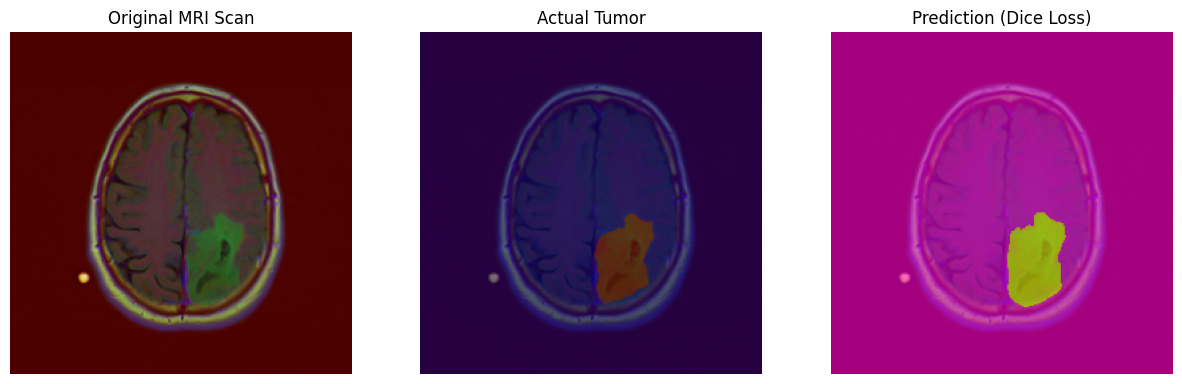

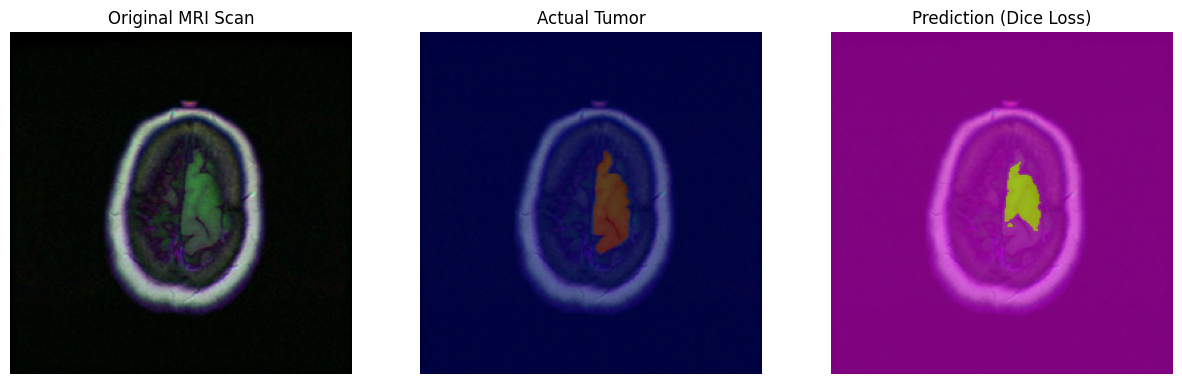

In [ ]:
## Show 3 random examples
import random
indices = random.sample(range(len(val_loader.dataset)), 3)

print("Visualizing Model Performance on Unseen Patients:")
for idx in indices:
    plot_prediction(model_dice, val_loader.dataset, idx)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_metrics(model, loader, threshold=0.5):
    model.eval()
    iou_scores = []
    dice_scores = []
    accuracies = []
    precisions = []
    recalls = []



    with torch.no_grad():
        for img, mask in loader:
            img, mask = img.to(DEVICE), mask.to(DEVICE)

            ## Prediction
            pred = model(img)
            pred = torch.sigmoid(pred) > threshold # Convert to 0 or 1

            ## using CPU for calculations
            pred = pred.cpu().view(-1).numpy()
            mask = mask.cpu().view(-1).numpy()

            # 1. IoU (Intersection over Union)
            intersection = (pred * mask).sum()
            union = pred.sum() + mask.sum() - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            iou_scores.append(iou)

            # 2. Dice Score
            dice = (2. * intersection + 1e-6) / (pred.sum() + mask.sum() + 1e-6)
            dice_scores.append(dice)


            if mask.sum() > 0:
                precisions.append(precision_score(mask, pred, zero_division=0))
                recalls.append(recall_score(mask, pred, zero_division=0))


    print("\n FINAL MODEL PERFORMANCE:")
    print(f"--------------------------------")
    print(f"IoU Score: {np.mean(iou_scores):.4f} ")
    print(f"Dice Score:{np.mean(dice_scores):.4f} ")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall:    {np.mean(recalls):.4f} ")
    print(f"--------------------------------")


In [ ]:
# getting the metrics
print("\n --------------Standard BCE Model----------------")
get_metrics(model_bce, val_loader)
print("\n\n ------------Proposed Dice Model--------------")
get_metrics(model_dice, val_loader)


 --------------Standard BCE Model----------------

 FINAL MODEL PERFORMANCE:
--------------------------------
IoU Score: 0.6637 
Dice Score:0.7965 
Precision: 0.9051
Recall:    0.7140 
--------------------------------


 ------------Proposed Dice Model--------------

 FINAL MODEL PERFORMANCE:
--------------------------------
IoU Score: 0.6922 
Dice Score:0.8177 
Precision: 0.8331
Recall:    0.8047 
--------------------------------
